# CVN modeling exercise HS21

### This notebook describes a modeling process based on the seminar Computational Visual Neuroscience and follows the necessary steps outlined there to build, optimise, and validate a model.

The app is built to use polynomial function and accepts an arbitrary number of parameters, thus modeling a polynomial of arbitrary order. It generates sample data based on parameters passed through the same polynomial function to which random offsets are added. Then it establishes a model based on computational ranges for each parameter, calculates candidate parameters using the maximum likelihood method, optimises them using k-fold validation, and finally calculates parameter variance using non-parametric bootstrapping.

The structure of the app is relatively simple, the <code>sample</code> and <code>model</code> classes define a the generated data and the model itself, respectively. These handle basic tasks concerning their individual structures, and not the modeling process itself, so they have been factored out of the main logic.

The rest of the notebook is about the generation, optimisation, and validation of the model's parameters and follows a rather linear approach, thus remains part of the main logic.

In this first code block, all the necessary dependencies are imported and the variables defining the program's behaviour are defined:


In [42]:
import numpy as np

from sample import Sample
from model import Model
from matplotlib import pyplot as plt


# Sample #

size = 50 # number of values to generate

parameters = [ # distribution parameters used
    3,
    0.13,
]

error = 0.64 # SD of the error added to each value

# Optimisation #

limits = [ # computational range for each parameter
    [1, 5],
    [-0.1, 0.15],
]

steps = 120 # number of optimisation cycles

k = 10 # number of splits for k-fold validation

bootstrap_cycles = 5 # number of time the bootstrapping is applied

Since the sample data generation and the modeling process are completely seperate, they do not use the same parameters and can thus differ in the number of parameters used, allowing for overfitting or underfitting of models.

Both the sample and the model are defined starting from the lowest exponent: $\sum_{k=0}^{n} f(a_kx^{k})$, where $a$ are the respective parameter values.

The sample variables consist of the size of the sample that's to be generated, the parameters to use in the generative function, as well as the standard deviation of the random gaussian error added to each data point.

The optimisation variables consist of a list of parameter limits, whose number defines the order of the polynomial model to be fitted, and whose values define the computational range of each parameter to be fitted.
There are further variables to define the number of optimisation cycles for the maximum likelihood function, as well as the $k$, or the number of splits, for the k-fold validation, and finally the number of times the bootstrapping is performed.

### Caution: calculating higher order polynomials is very resource intensive, and the time to process all the individual modeling steps increases exponentially with the number of parameters added. Up to about a third order polynomial will probably run in a reasonable amount of time, if the size of the sample data and the number of optimisation cylces is kept low.

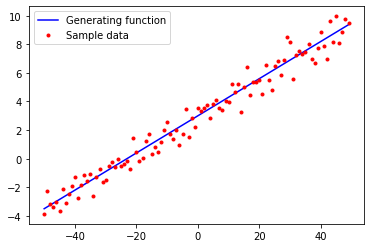

In [43]:
#######################
# Object Construction #
#######################

# generate sample data based on given params
sample = Sample(size, parameters, error)

data = sample.get_sample()
sample.save_sample(data)

# generate the model used to find parameters
model = Model()

# initialise a numpy random object
rng = np.random.default_rng()

generating_function, = plt.plot(data[0], model.func(parameters, data[0]), 'b-')
generating_function.set_label("Generating function")

data_points, = plt.plot(data[0], data[1], 'r.')
data_points.set_label("Sample data")

plt.legend()
plt.show()

Next is a short block that constructs the <code>Sample</code> and <code>Model</code> objects from their respective classes, using the provided variables.

<code>Sample</code> is then used to generate a data set to be used to fit the <code>Model</code> against, which is also saved to a .csv file.

Further, a <code>numpy</code> random generator is initialised, which is used in various parts of the modeling logic.

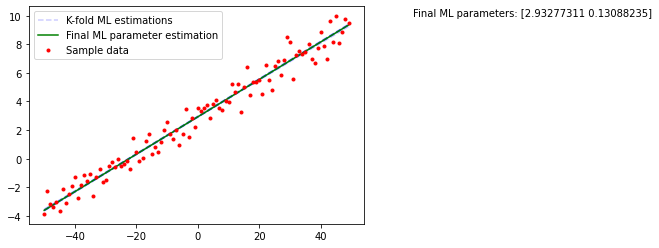

In [44]:
################
# Optimisation #
################

# split the data into k folds to use as training and testing sets
splits = np.hsplit(rng.permutation(data, 1), k)

# initialise an array of length k to store the estimated parameter of each train & test iteration
max_likelihoods = np.empty((k, len(parameters)))

# use each fold once as a testing set while the other k-1 folds are used as training sets
for f in range(len(splits)):
    test = splits[f]
    train = np.sort(np.column_stack(np.delete(splits, f, 0)))

    # calculate ml parameters for each fold
    max_likelihood_f = model.optimise(train, steps, limits)

    max_likelihoods[f] = max_likelihood_f

    fold_line, = plt.plot(train[0], model.func(max_likelihood_f, train[0]), 'b--', alpha=0.2)

# calculate the mean of each parameter from all k parameter sets to use as final ml estimate
best_ml = np.mean(max_likelihoods, axis=0)

# plot the final ml estimate in green
final_ml_line, = plt.plot(data[0], model.func(best_ml, data[0]), 'g-')
final_ml_line.set_label("Final ML parameter estimation")

data_points, = plt.plot(data[0], data[1], 'r.')
data_points.set_label("Sample data")

fold_line.set_label("K-fold ML estimations")

plt.legend()

plt.text(70, 10, f'Final ML parameters: {np.array2string(best_ml)}')
plt.show()

This block deals with fitting the model to the generated data using a k-fold validation approach with a maximum likelihood calculation.

First, arrays are intialised to hold both the folds for the k-fold validation, as well as their respective maximum likelihoods. Each of those folds is then, in turn, assigned as the test set, while the others are used as the training set. For each of those combinations, the model is fitted against the training set and the parameters with the maximum likelihood are selected. To get a final parameter set, the parameteres with the highest likelihood from each fold are averaged.

The functions of the parameters of each fold are plotted in low-opacity blue, and the function of the final parameter estimation is plotted in green.

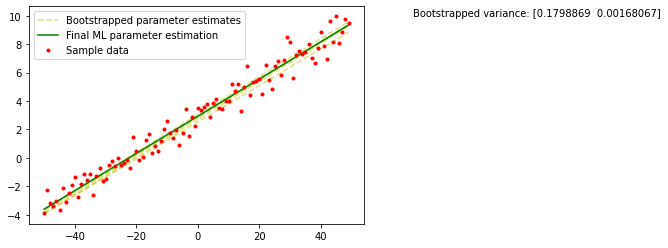

In [45]:
bootstrapped_samples = np.empty((bootstrap_cycles, size * 2))

bootstrap_params = np.empty((bootstrap_cycles, len(parameters)))


def get_sample_from_model():
    poly = np.polynomial.polynomial.Polynomial(best_ml)

    return np.sort(poly(rng.integers(low=-size, high=size, size=size*2)))


for i in range(bootstrap_cycles):
    bootstrapped_samples[i] = get_sample_from_model()

    indexed_sample = np.stack((np.arange(-size, size), bootstrapped_samples[i]), axis=0)

    bootstrap_params[i] = model.optimise(indexed_sample, steps, limits)

    bootstrap_lines, = plt.plot(data[0], model.func(bootstrap_params[i], data[0]), 'y--', alpha=0.5)


bootstrap_var = bootstrap_params.T.std(axis=1)

final_ml_line, = plt.plot(data[0], model.func(best_ml, data[0]), 'g-')
final_ml_line.set_label("Final ML parameter estimation")

data_points, = plt.plot(data[0], data[1], 'r.')
data_points.set_label("Sample data")

bootstrap_lines.set_label("Bootstrapped parameter estimates")

plt.legend()

plt.text(70, 10, f'Bootstrapped variance: {np.array2string(bootstrap_var)}')
plt.show()

Finally, the bootstrapping is applied to find the variance of the parameters of the fitted model.

To do this, a function had to be implemented that would generate a sample with the same size as the original sample from the parameters of the fitted model. This <code>get_sample_from_model()</code> function creates a new polynomial from the established parameters and is then used to generate a new data set with random values based on that new maximum likelihood polynomial in each bootstrapping cycle.

The generated sample is then used to fit a new model against, which produces a new set of parameters. By calculating the standard deviation of these bootstrapped, a reasonable estimate of the variability of the found parameters of the original model can be obtained.